In [40]:
import os
from utils import *
import optuna

In [41]:
data, usermap, itemmap, users = load_data2()
data_train, data_test, data_val=split_data2(data, 0.2, 0.2)

In [42]:
study_name = "rating+ranking"
study = optuna.create_study(
    study_name=study_name,
    storage=get_database_url(),
    load_if_exists=True,
    direction="maximize",
)

[I 2024-01-05 23:01:45,586] A new study created in memory with name: rating+ranking


In [43]:
from Evaluation.Evaluator import EvaluatorHoldout

cutoff_list=[5, 10, 15]

evaluator_validation = EvaluatorHoldout(data_val, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(data_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 2149 (17.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2629 (20.8%) Users that have less than 1 test interactions


In [44]:
study_name = "P3Beta"
study = optuna.create_study(
    study_name=study_name,
    storage=get_database_url(),
    load_if_exists=True,
    direction="maximize",
)

from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

def objective(trial):
    topK = trial.suggest_int('topK', 1, 1000)
    alpha = trial.suggest_float('alpha', 0, 2)
    beta = trial.suggest_float('beta', 0, 2)
    implicit = trial.suggest_categorical('implicit', [True, False])
    normalize_similarity = trial.suggest_categorical('normalize_similarity', [True, False])
    
    recommender = RP3betaRecommender(data_train, verbose=False)
    recommender.fit(
        topK=topK,
        alpha=alpha,
        beta=beta,
        implicit=implicit,
        normalize_similarity=normalize_similarity,
    )
    _, _, ev_map, _, _ = evaluator(recommender, data_train, data_val)
    
    return ev_map

study.optimize(objective, n_trials=150)

[I 2024-01-05 23:01:50,089] A new study created in memory with name: P3Beta
[W 2024-01-05 23:01:55,429] Trial 0 failed with parameters: {'topK': 943, 'alpha': 0.6858132073165291, 'beta': 1.6002414177088227, 'implicit': True, 'normalize_similarity': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\francesco\miniconda3\envs\RecSysFramework\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\2301996775.py", line 19, in objective
    recommender.fit(
  File "c:\Users\francesco\Desktop\rcs\Recommenders\GraphBased\RP3betaRecommender.py", line 100, in fit
    relevant_items_partition = np.argpartition(-row_data, self.topK-1, axis=0)[:self.topK]
  File "<__array_function__ internals>", line 200, in argpartition
  File "c:\Users\francesco\miniconda3\envs\RecSysFramework\lib\site-packages\numpy\core\fromnumeric.py", line 

KeyboardInterrupt: 

In [45]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

rp3beta_recommender = RP3betaRecommender(data_train+data_val, verbose=False)
rp3beta_recommender.fit(topK=56, alpha=0.23624157463659923, beta=0.22551648560446969, implicit=False, normalize_similarity=True)

In [46]:
study_name = "Easer"
study = optuna.create_study(
    study_name=study_name,
    storage=get_database_url(),
    load_if_exists=True,
    direction="maximize",
)

from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

def objective(trial):
    topK = trial.suggest_int('topK', 0, 1000)
    l2_norm = trial.suggest_float('l2_norm', 1, 1e10, log=True)
    
    recommender = EASE_R_Recommender(data_train, verbose=False)
    recommender.fit(
        topK=topK if topK > 0 else None,
        l2_norm=l2_norm,
        normalize_matrix=False,
    )
    _, _, ev_map, _, _ = evaluator(recommender, data_train, data_val)
    
    return ev_map

study.optimize(objective, n_trials=150)

[I 2024-01-05 23:02:24,461] A new study created in memory with name: Easer
c:\Users\francesco\Desktop\rcs\Recommenders\EASE_R\EASE_R_Recommender.py:73: RuntimeWarning: invalid value encountered in divide
  B = P / (-np.diag(P))
[W 2024-01-05 23:04:18,420] Trial 0 failed with parameters: {'topK': 488, 'l2_norm': 301430089.03296417} because of the following error: MemoryError((22222, 22222), dtype('float64')).
Traceback (most recent call last):
  File "c:\Users\francesco\miniconda3\envs\RecSysFramework\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\1214876402.py", line 16, in objective
    recommender.fit(
  File "c:\Users\francesco\Desktop\rcs\Recommenders\EASE_R\EASE_R_Recommender.py", line 93, in fit
    self.W_sparse = check_matrix(B, format='npy', dtype=float)
  File "c:\Users\francesco\Desktop\rcs\Recommenders\Recommender_utils.py", line 45, in check_matrix
    ret

MemoryError: Unable to allocate 3.68 GiB for an array with shape (22222, 22222) and data type float64

In [ ]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

easer_recommender = EASE_R_Recommender(data_train+data_val)
easer_recommender.fit(**study.best_params)

In [ ]:
user_id=50

In [ ]:
rp3beta_score = rp3beta_recommender._compute_item_score(user_id).flatten()
rp3beta_score

array([0.        , 0.        , 0.00590169, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
easer_score = easer_recommender._compute_item_score(user_id).flatten()
easer_score

array([ 0.02114375,  0.04022163,  0.01252108, ...,  0.        ,
       -0.00013097, -0.00046271])

C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\623488812.py:15: RuntimeWarning: divide by zero encountered in divide
  lminusinf_rp3beta_scores = rp3beta_score / lminusinf_rp3beta
C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\623488812.py:15: RuntimeWarning: invalid value encountered in divide
  lminusinf_rp3beta_scores = rp3beta_score / lminusinf_rp3beta


[0.         0.         0.00590169 ... 0.         0.         0.        ] 0.38037494109382497 0.8904933236093673 0.38037494109382497 0.0


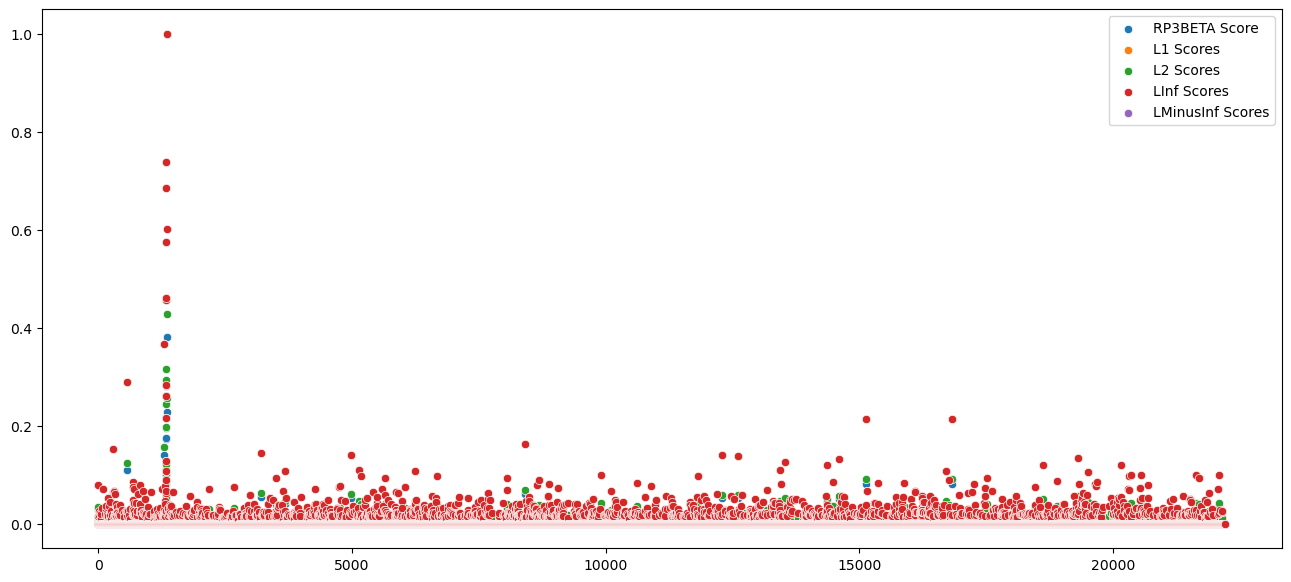

In [ ]:
import seaborn as sns
from numpy import linalg as LA
import matplotlib.pyplot as plt

l1_rp3beta = LA.norm([rp3beta_score], 1)
l1_rp3beta_scores = rp3beta_score / l1_rp3beta

l2_rp3beta = LA.norm([rp3beta_score], 2)
l2_rp3beta_scores = rp3beta_score / l2_rp3beta

linf_rp3beta = LA.norm(rp3beta_score, np.inf)
linf_rp3beta_scores = rp3beta_score / linf_rp3beta

lminusinf_rp3beta = LA.norm(rp3beta_score, -np.inf)
lminusinf_rp3beta_scores = rp3beta_score / lminusinf_rp3beta

print(rp3beta_score, l1_rp3beta, l2_rp3beta, linf_rp3beta, lminusinf_rp3beta)

_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=rp3beta_score)
ax = sns.scatterplot(data=l1_rp3beta_scores) 
ax = sns.scatterplot(data=l2_rp3beta_scores) 
ax = sns.scatterplot(data=linf_rp3beta_scores) 
ax = sns.scatterplot(data=lminusinf_rp3beta_scores) 
ax.legend(["RP3BETA Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\176586920.py:11: RuntimeWarning: divide by zero encountered in divide
  lminusinf_easer_scores = easer_score / lminusinf_easer
C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\176586920.py:11: RuntimeWarning: invalid value encountered in divide
  lminusinf_easer_scores = easer_score / lminusinf_easer


[ 0.02114375  0.04022163  0.01252108 ...  0.         -0.00013097
 -0.00046271] 28.691284782000096 0.44110194798907587 0.1593164732952774 0.0


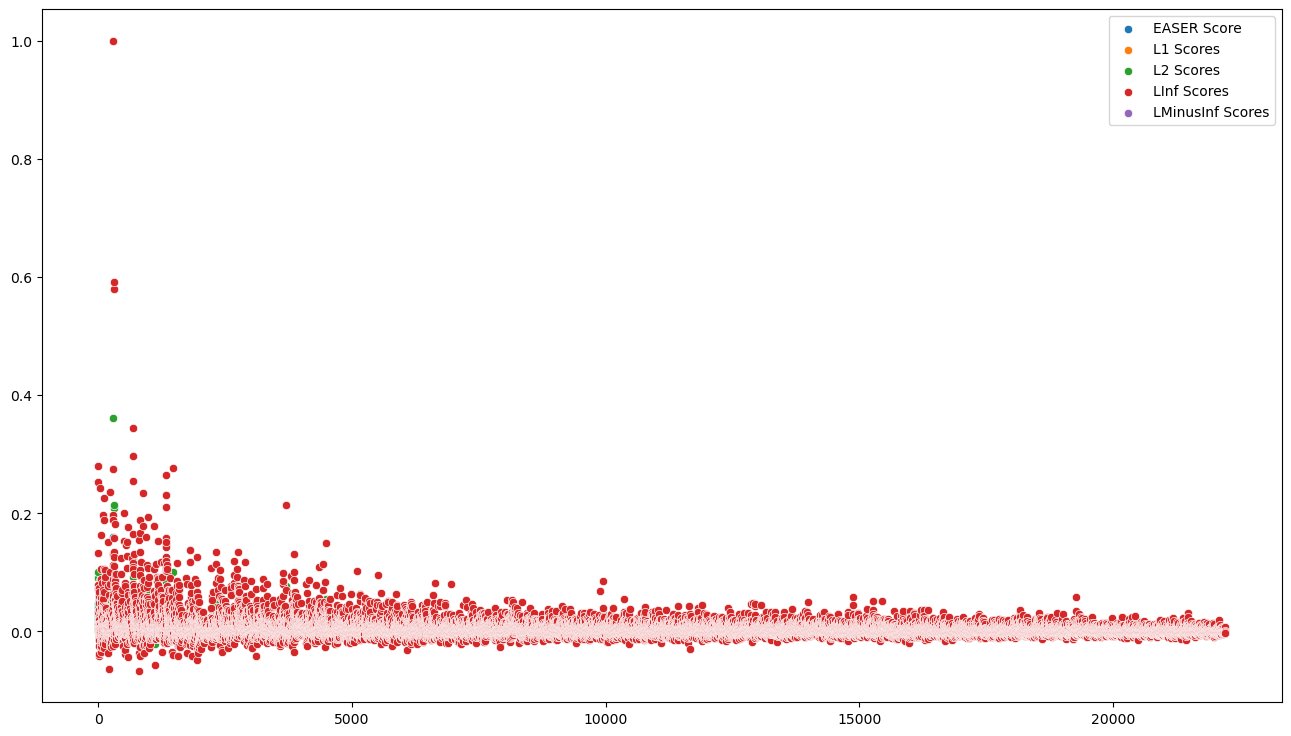

In [ ]:
l1_easer = LA.norm(easer_score, 1)
l1_easer_scores = easer_score / l1_easer

l2_easer = LA.norm(easer_score, 2)
l2_easer_scores = easer_score / l2_easer

linf_easer = LA.norm(easer_score, np.inf)
linf_easer_scores = easer_score / linf_easer

lminusinf_easer = LA.norm(easer_score, -np.inf)
lminusinf_easer_scores = easer_score / lminusinf_easer

print(easer_score, l1_easer, l2_easer, linf_easer, lminusinf_easer)

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=easer_score)
ax = sns.scatterplot(data=l1_easer_scores) 
ax = sns.scatterplot(data=l2_easer_scores) 
ax = sns.scatterplot(data=linf_easer_scores) 
ax = sns.scatterplot(data=lminusinf_easer_scores) 
ax.legend(["EASER Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

C:\Users\francesco\AppData\Local\Temp\ipykernel_13072\330175764.py:6: RuntimeWarning: invalid value encountered in add
  lminusinf_new_scores = lambda_weights * lminusinf_easer_scores + (1 - lambda_weights) * lminusinf_rp3beta_scores


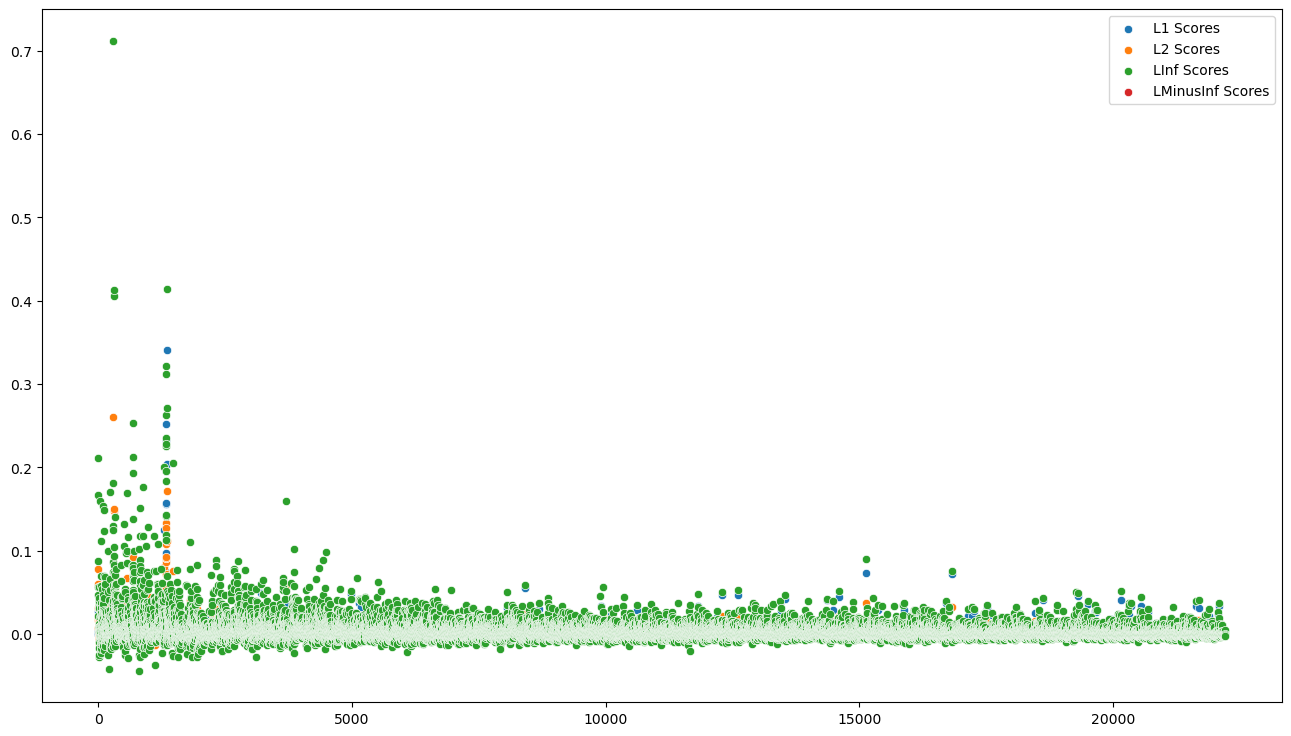

In [ ]:
lambda_weights = 0.66

l1_new_scores = lambda_weights * l1_easer_scores + (1 - lambda_weights) * l1_rp3beta_scores
l2_new_scores = lambda_weights * l2_easer_scores + (1 - lambda_weights) * l2_rp3beta_scores
linf_new_scores = lambda_weights * linf_easer_scores + (1 - lambda_weights) * linf_rp3beta_scores
lminusinf_new_scores = lambda_weights * lminusinf_easer_scores + (1 - lambda_weights) * lminusinf_rp3beta_scores

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=l1_new_scores)
ax = sns.scatterplot(data=l2_new_scores) 
ax = sns.scatterplot(data=linf_new_scores) 
ax = sns.scatterplot(data=lminusinf_new_scores) 
ax.legend(["L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

In [ ]:
from Recommenders.BaseRecommender import BaseRecommender
import scipy.sparse as sps

class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights



In [ ]:
recommender_object = DifferentLossScoresHybridRecommender(data_train, rp3beta_recommender, easer_recommender)

for norm in [1, 2, np.inf, -np.inf]:

    recommender_object.fit(norm, alpha = 0.66)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
    print("Norm: {}, Result: {}".format(norm, result_df.loc[10]["MAP"]))

DifferentLossScoresHybridRecommender: URM Detected 422 ( 3.3%) users with no interactions.
DifferentLossScoresHybridRecommender: URM Detected 348 ( 1.6%) items with no interactions.
EvaluatorHoldout: Processed 10463 (100.0%) in 2.58 min. Users per second: 68
Norm: 1, Result: 0.013935428547155604
EvaluatorHoldout: Processed 10463 (100.0%) in 2.52 min. Users per second: 69
Norm: 2, Result: 0.018445834831431758
EvaluatorHoldout: Processed 10463 (100.0%) in 1.47 min. Users per second: 119
Norm: inf, Result: 0.02601167909898682


ValueError: Norm -inf of item weights for recommender 1 is zero. Avoiding division by zero

In [ ]:
result_df

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.071681,0.08795,0.054104,0.040787,0.049995,0.149908,0.084152,0.061665,0.27516,0.174754,...,0.8279,0.227805,0.8279,0.096582,10.482216,0.995851,0.280856,0.808209,1.787096,0.20831
10,0.058779,0.099109,0.083182,0.026012,0.043702,0.163266,0.087099,0.068883,0.374749,0.204921,...,0.8279,0.310255,0.8279,0.131808,10.932182,0.996755,0.38329,0.842902,1.704731,0.417656
15,0.050986,0.113004,0.104445,0.019508,0.042879,0.167644,0.091716,0.068522,0.430374,0.218733,...,0.8279,0.356306,0.8279,0.157139,11.238459,0.997455,0.45695,0.866517,1.594299,0.630876
